In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

weeks = np.array([3,4,5,6,7,8,9])
dates = ['2016-01-01','2016-02-01','2016-03-01','2016-04-01','2016-05-01','2016-06-01','2016-07-01']
vals = np.array([6.702887,6.964212,7.045448,6.998177,7.112790,6.996705,6.937715])
df = pd.DataFrame(vals,columns=['vals'])
df.index = pd.DatetimeIndex(dates)
ts = df['vals']

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=3)
    rolstd = pd.rolling_std(timeseries, window=3)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
#     print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

In [3]:
ts

2016-01-01    6.702887
2016-02-01    6.964212
2016-03-01    7.045448
2016-04-01    6.998177
2016-05-01    7.112790
2016-06-01    6.996705
2016-07-01    6.937715
Name: vals, dtype: float64

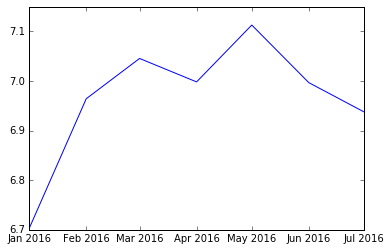

In [4]:
plt.plot(ts)

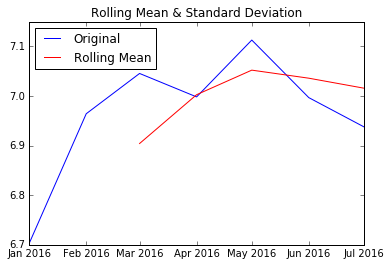

In [5]:
test_stationarity(ts)

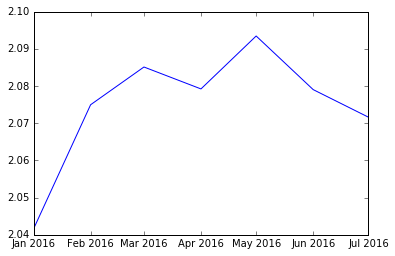

In [6]:
ts_log = np.log(ts+1)
plt.plot(ts_log)

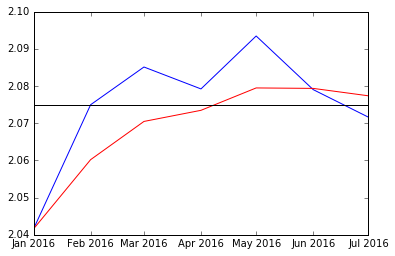

In [7]:
expwighted_avg = pd.ewma(ts_log, halflife=3)

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.axhline(ts_log.mean(),color='black')

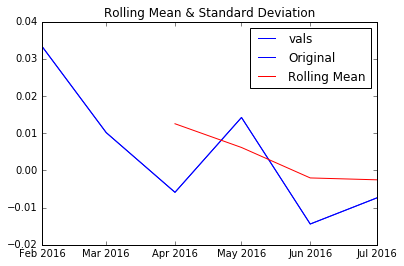

In [8]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

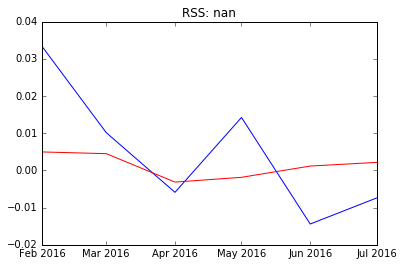

In [9]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff[1:])**2))

In [10]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

2016-02-01    0.004966
2016-03-01    0.004500
2016-04-01   -0.003139
2016-05-01   -0.001856
2016-06-01    0.001167
dtype: float64
2016-02-01    0.004966
2016-03-01    0.009465
2016-04-01    0.006326
2016-05-01    0.004470
2016-06-01    0.005637
dtype: float64


2016-01-01    2.041595
2016-02-01    2.046561
2016-03-01    2.051060
2016-04-01    2.047922
2016-05-01    2.046065
dtype: float64

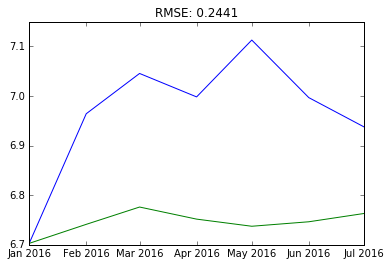

In [11]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)-1
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))